In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from mnist import MNIST
import random
import timeit
import csv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

In [2]:
# Task(a): load MNIST data
train_data = pandas.read_csv('data/train.csv', dtype=np.float32).values
test_images = pandas.read_csv('data/test.csv', dtype=np.float32).values
train_images = train_data[:,1:]
train_labels = train_data[:,0]

In [11]:
def vector_to_mat(vector, size=(28,28)):
    return vector.reshape(28,28)

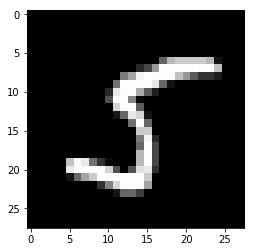

In [13]:
# Task(b): show a number
index = random.randrange(0, len(train_images))
plt.imshow(vector_to_mat(train_images[index]), cmap='gray')

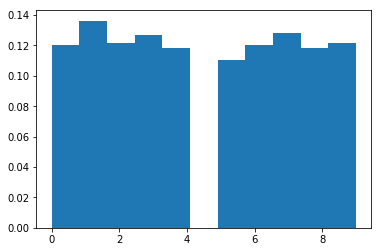

In [7]:
# Task(c): prior probability of classes
# digit_count = [train_labels.count(i) for i in range(10)]
plt.hist(train_labels, density=True, bins=11)
plt.show()

In [8]:
# L2 norm
def L2(v1, v2):
    return np.sum((v1-v2)**2)

# Compare an image with a list of targets and return the nearest one
def nearest_norm(original, targets):
    norms = [(k, L2(original, targets[k])) for k in range(len(targets))]
    return sorted(norms, key=lambda x: x[1])

In [9]:
# Task(d): find nearest neighbor for each digit image
digit_indices = [list(train_labels).index(i) for i in range(10)]
best_match = []

for i, j in enumerate(digit_indices):
    # print("digit {}".format(i))
    best_match.append(nearest_norm(train_images[j], train_images)[1][0])

/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


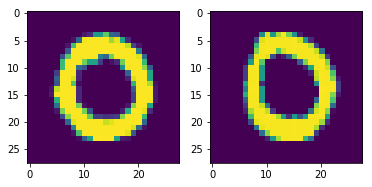

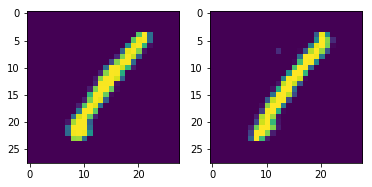

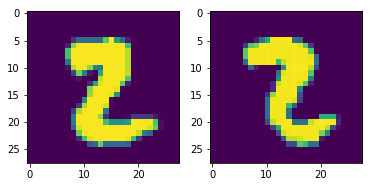

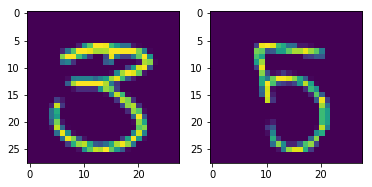

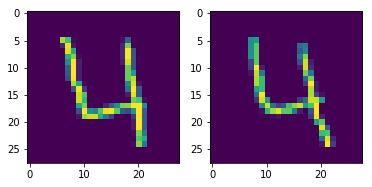

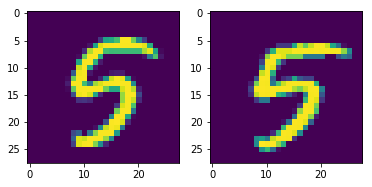

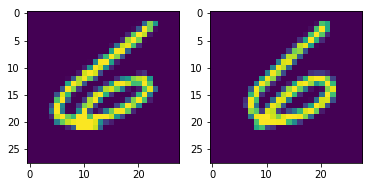

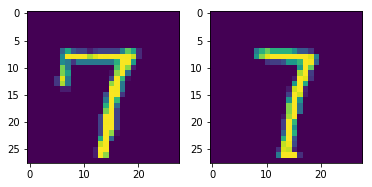

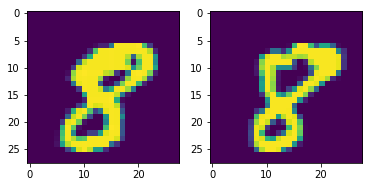

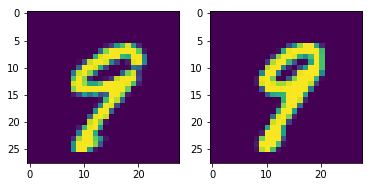

In [12]:
# Plot the nearest digits
for i, bm in enumerate(best_match):
    #print("best match for digit {}".format(i))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(vector_to_mat(train_images[digit_indices[i]]))
    axs[1].imshow(vector_to_mat(train_images[bm]))
    fig.show()

In [15]:
# Task(e): genuine matches and impostor matches between 0 and 1
# e-1. get images labeled 0 and 1
images_0 = train_images[train_labels == 0]
images_1 = train_images[train_labels == 1]

# e-2. compute genuine distances and impostor distances
genuine_dist_0 = euclidean_distances(images_0, images_0)
genuine_dist_1 = euclidean_distances(images_1, images_1)
impostor_0_1 = euclidean_distances(images_0, images_1)

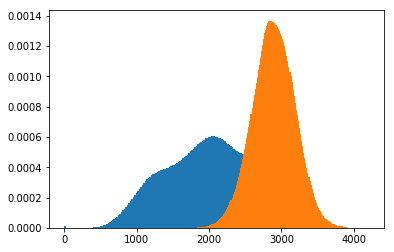

In [18]:
# Draw the hist using the distances
fig, ax = plt.subplots()
g_0_flat = genuine_dist_0.flatten()
g_1_flat = genuine_dist_1.flatten()
i_flat = impostor_0_1.flatten()
# g_flat = np.append(g_0_flat[:len(g_0_flat)/2], g_1_flat[:len(g_1_flat)/2])
g_flat = np.append(g_0_flat, g_1_flat)

ax.hist(g_flat, bins=200, histtype='stepfilled', density=True)
ax.hist(i_flat[:len(i_flat)], bins=200, histtype='stepfilled', density=True)

fig.show()

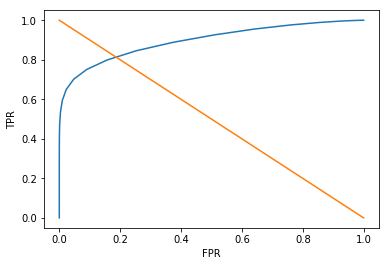

In [23]:
# Task(f): ROC curve from the above sets of distances
g_min, i_min = np.min(g_flat), np.min(i_flat)
g_max, i_max = np.max(g_flat), np.max(i_flat)
roc_min = np.min([g_min, i_min])
roc_max = np.min([g_max, i_max])

# ROC dimensions
TPRs = []
FPRs = []

step = 100
steps = int(roc_max/step)
for i in range(steps):
    _threshold = step*i
    # print("threshold = {}".format(_threshold))
    tp = len(g_flat[np.where(g_flat <= _threshold)])
    #fn = len(g_flat[np.where(g_flat >= np.max([i_min, _threshold]))])
    fn = len(g_flat[np.where(g_flat >= _threshold)])
    tpr = float(tp)/(tp + fn)
    TPRs.append(tpr)
    
    fp = len(i_flat[np.where(i_flat <= _threshold)])
    tn = len(i_flat[np.where(i_flat >= _threshold)])    
    fpr = float(fp)/(fp + tn)
    FPRs.append(fpr)

fig, ax = plt.subplots(1,1)
plt.xlabel("FPR")
plt.ylabel("TPR")
ax.plot(FPRs, TPRs)
ax.plot(np.linspace(0,1,100), np.linspace(1,0,100))

fig.show()

In [24]:
# EER
EER_thre = 0.05
EERs = []
for i in range(len(TPRs)):
    if abs(TPRs[i] + FPRs[i] - 1) < EER_thre:
        EERs.append([FPRs[i], TPRs[i]])
EERs = np.array(EERs)        
print("Intersection is at: {}".format(EERs))
print("Equal error rate is: {}".format(EERs[0][0]))

# Randomly guess...
random_guess_rate = 0.5

Intersection is at: [[0.15723852 0.79894535]]
Equal error rate is: 0.157238516255


In [25]:
# Task(g): implement a knn classifier
def knn(train_x, train_y, input_x, k):
    _predictions = []    
    dists = euclidean_distances(input_x, train_x)
    for d in dists:        
        dist_index = np.argsort(d)[0:k]
        count_hash = {}
        for i in train_y[dist_index]:
            if i in count_hash: 
                count_hash[i] += 1
            else: 
                count_hash[i] = 1
        _predictions.append(sorted(count_hash.items(), key=lambda t: t[1], reverse=True)[0][0])
    return _predictions

In [26]:
# Task(h): 3-fold cross validation
def k_fold(data_set, n_splits):
    if n_splits <= 0: return False
    _indices = []
    for i in range(len(data_set)):
        m = i % (n_splits)
        if len(_indices) == m:
            _indices.append([i])
        elif len(_indices) > m:
            _indices[m].append(i)
        else:
            raise Exception('k_fold error: index is messed up.')
    return _indices

In [16]:
# try each set of indices as test indices
k_options = range(1, 11)
accuracies = {}

for k in k_options:
    print("k = {}".format(k))
    k_fold_indices = k_fold(train_images, 3)
    k_fold_accuracies = []
    for i, test_indices in enumerate(k_fold_indices):
        l = len(k_fold_indices)
        train_indices = np.array(k_fold_indices[list(range(l)).pop(i%l)]).flatten()
        X_train, y_train = train_images[train_indices], train_labels[train_indices]
        X_test, y_test = train_images[test_indices], train_labels[test_indices]
        print("knn iteration {}".format(i))
        predict = knn(X_train, y_train, X_test, k)
        accuracy = accuracy_score(y_test, predict) * 100
        print("accuracy = {}".format(accuracy))
        k_fold_accuracies.append(accuracy)

    avg_accuracy = float(np.sum(k_fold_accuracies)) / len(k_fold_accuracies)
    print("average accuracy by 3-fold cross validation: {}".format(avg_accuracy))

k = 1
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
knn iteration 2
accuracy = 100.0
average accuracy by 3-fold cross validation: 100.0
k = 2
knn iteration 0
accuracy = 98.0928571429
knn iteration 1
accuracy = 97.9285714286
knn iteration 2
accuracy = 98.0212872348
average accuracy by 3-fold cross validation: 98.0142386021
k = 3
knn iteration 0
accuracy = 97.8285714286
knn iteration 1
accuracy = 97.7214285714
knn iteration 2
accuracy = 97.7784127438
average accuracy by 3-fold cross validation: 97.7761375813
k = 4
knn iteration 0
accuracy = 97.3428571429
knn iteration 1
accuracy = 97.1428571429
knn iteration 2
accuracy = 97.3212372312
average accuracy by 3-fold cross validation: 97.268983839
k = 5
knn iteration 0
accuracy = 97.05
knn iteration 1
accuracy = 97.0357142857
knn iteration 2
accuracy = 97.0712193728
average accuracy by 3-fold cross validation: 97.0523112195
k = 6
knn iteration 0
accuracy = 96.7785714286
knn iteration 1
accuracy = 96.8
knn iteration 2
accura

In [53]:
# Task(i): confusion matrix
k_fold_indices = k_fold(train_images, 3)
l = len(k_fold_indices)
test_indices = np.array(k_fold_indices[0]).flatten()
train_indices = np.array(k_fold_indices[list(range(l)).pop(0)]).flatten()
X_train, y_train = train_images[train_indices], train_labels[train_indices]
X_test, y_test = train_images[test_indices], train_labels[test_indices]
predict = knn(X_train, y_train, X_test, 3)

con_matrix = confusion_matrix(y_test, predict)
print("Confusion matrix: ")
print(con_matrix)

Confusion matrix: 
[[1402    1    0    0    0    1    2    0    0    0]
 [   0 1538    1    1    1    0    0    0    1    0]
 [   4   18 1333    1    1    1    0   20    8    2]
 [   3    3    5 1410    1    5    1    5    6   11]
 [   2    8    0    0 1326    0    3    1    0   27]
 [   2    2    0   18    1 1218    5    0    3    6]
 [   5    5    0    0    1    1 1357    0    1    0]
 [   0   19    3    0    1    0    0 1425    0   10]
 [   4   13    0    7    4    7    3    0 1323   12]
 [   5    2    1    2    4    2    1   14    3 1357]]


In [52]:
diag = np.array([float(con_matrix[i][i]) for i in range(len(con_matrix))])
actual_sum = np.sum(con_matrix, axis=1)
tricky_label = np.argsort(diag / actual_sum)[0]
print("Most tricky digit to classify is: {}".format(tricky_label))

Most tricky digit to classify is: 2


In [161]:
# Task(j): Re-train knn with all train data and test data
# k_options = [i for i in range(1,30) if i%3 == 0]
# k_options = range(1, 11)
# accuracies = {}

start_time = timeit.default_timer()
predict_all = knn(train_images, train_labels, test_images, 1)
print(timeit.default_timer() - start_time)
# for k in k_options:
#     print("k = {}".format(k))
#     predict_all = knn(train_images, train_labels, test_images, k)
#     accuracy = accuracy_score(test_labels, predict_all) * 100
#     accuracies[k] = accuracy
#     print("when k = {}, accuracy = {}".format(k, accuracy))

103.65220499


In [162]:
# sorted_results = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)
# best_k = sorted_results[0][0]
# best_accuracy = sorted_results[0][1]
# print("Best k = {}, accuracy = {}%".format(best_k, best_accuracy))
str = "ImageId,Label\n"
print(len(test_images))
predict_ret = np.transpose([range(1,len(predict_all)+1), predict_all])
predict_ret = np.array(predict_ret, dtype=np.int32)

with open('prediction.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(predict_ret)

28000


In [55]:
# try different k-folds
k_folds_options = range(2, 11)
k_options = range(1, 11)

for k1 in k_options: 
    print("k of knn = {}".format(k1))
    for k in k_folds_options:
        print("k-folds = {}".format(k))
        start_time = timeit.default_timer()    
        k_fold_indices = k_fold(train_images, k)
        k_fold_accuracies = []
        for i, test_indices in enumerate(k_fold_indices):
            l = len(k_fold_indices)
            train_indices = np.array(k_fold_indices[list(range(l)).pop(i%l)]).flatten()
            X_train, y_train = train_images[train_indices], train_labels[train_indices]
            X_test, y_test = train_images[test_indices], train_labels[test_indices]
            print("knn iteration {}".format(i))
            predict = knn(X_train, y_train, X_test, k1)
            accuracy = accuracy_score(y_test, predict) * 100
            print("accuracy = {}".format(accuracy))
            k_fold_accuracies.append(accuracy)

        avg_accuracy = float(np.sum(k_fold_accuracies)) / len(k_fold_accuracies)
        print("average accuracy by {}-fold cross validation: {}".format(k, avg_accuracy))
        print("{}-fold cross validation cost {} seconds".format(k, timeit.default_timer() - start_time))

k of knn = 1
k-folds = 2
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
average accuracy by 2-fold cross validation: 100.0
2-fold cross validation cost 68.4740920067 seconds
k-folds = 3
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
knn iteration 2
accuracy = 100.0
average accuracy by 3-fold cross validation: 100.0
3-fold cross validation cost 41.708466053 seconds
k-folds = 4
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
knn iteration 2
accuracy = 100.0
knn iteration 3
accuracy = 100.0
average accuracy by 4-fold cross validation: 100.0
4-fold cross validation cost 30.1798620224 seconds
k-folds = 5
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
knn iteration 2
accuracy = 100.0
knn iteration 3
accuracy = 100.0
knn iteration 4
accuracy = 100.0
average accuracy by 5-fold cross validation: 100.0
5-fold cross validation cost 23.9397039413 seconds
k-folds = 6
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy 

accuracy = 96.7238095238
knn iteration 7
accuracy = 97.0476190476
average accuracy by 8-fold cross validation: 96.930952381
8-fold cross validation cost 14.8181159496 seconds
k-folds = 9
knn iteration 0
accuracy = 96.6359545747
knn iteration 1
accuracy = 96.8716520249
knn iteration 2
accuracy = 96.8716520249
knn iteration 3
accuracy = 96.828797943
knn iteration 4
accuracy = 96.9359331476
knn iteration 5
accuracy = 96.8502249839
knn iteration 6
accuracy = 96.7852550364
knn iteration 7
accuracy = 96.7638234033
knn iteration 8
accuracy = 96.678096871
average accuracy by 9-fold cross validation: 96.8023766677
9-fold cross validation cost 13.2950539589 seconds
k-folds = 10
knn iteration 0
accuracy = 96.6666666667
knn iteration 1
accuracy = 96.7857142857
knn iteration 2
accuracy = 96.880952381
knn iteration 3
accuracy = 96.4761904762
knn iteration 4
accuracy = 96.1666666667
knn iteration 5
accuracy = 97.0476190476
knn iteration 6
accuracy = 96.8333333333
knn iteration 7
accuracy = 96.9523809

accuracy = 96.1142857143
knn iteration 1
accuracy = 96.6095238095
knn iteration 2
accuracy = 96.2476190476
knn iteration 3
accuracy = 96.6
average accuracy by 4-fold cross validation: 96.3928571429
4-fold cross validation cost 33.6930038929 seconds
k-folds = 5
knn iteration 0
accuracy = 96.3333333333
knn iteration 1
accuracy = 96.2619047619
knn iteration 2
accuracy = 96.0833333333
knn iteration 3
accuracy = 95.9285714286
knn iteration 4
accuracy = 95.9880952381
average accuracy by 5-fold cross validation: 96.119047619
5-fold cross validation cost 26.8084158897 seconds
k-folds = 6
knn iteration 0
accuracy = 95.6571428571
knn iteration 1
accuracy = 95.7571428571
knn iteration 2
accuracy = 95.3
knn iteration 3
accuracy = 95.6285714286
knn iteration 4
accuracy = 95.6
knn iteration 5
accuracy = 96.1714285714
average accuracy by 6-fold cross validation: 95.6857142857
6-fold cross validation cost 21.6761279106 seconds
k-folds = 7
knn iteration 0
accuracy = 95.5333333333
knn iteration 1
accura

accuracy = 94.5714285714
knn iteration 7
accuracy = 94.9523809524
average accuracy by 8-fold cross validation: 94.7928571429
8-fold cross validation cost 15.007185936 seconds
k-folds = 9
knn iteration 0
accuracy = 93.9790014999
knn iteration 1
accuracy = 94.3646882366
knn iteration 2
accuracy = 94.4718234412
knn iteration 3
accuracy = 94.536104564
knn iteration 4
accuracy = 95.0074994643
knn iteration 5
accuracy = 94.3861152775
knn iteration 6
accuracy = 94.2991855979
knn iteration 7
accuracy = 94.4920702958
knn iteration 8
accuracy = 94.5349335619
average accuracy by 9-fold cross validation: 94.4523802154
9-fold cross validation cost 13.4710390568 seconds
k-folds = 10
knn iteration 0
accuracy = 94.0238095238
knn iteration 1
accuracy = 94.3571428571
knn iteration 2
accuracy = 94.2857142857
knn iteration 3
accuracy = 93.7619047619
knn iteration 4
accuracy = 94.3571428571
knn iteration 5
accuracy = 94.5952380952
knn iteration 6
accuracy = 94.5
knn iteration 7
accuracy = 94.2619047619
knn

In [ ]:
"""
k = 2, 2-fold cross validation: 100.0
98.2928571429

"""